In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

import torchvision
import torchvision.transforms as T

%matplotlib inline
%load_ext autoreload
%autoreload 2

sys.path.append('../')

from utils import tonp
import utils

torch.set_grad_enabled(False)
device = torch.device('cuda')

import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["figure.facecolor"] = 'white'

## Loading task encoder and retrieving tasks

In [2]:
TASK_TYPE = 'resnet18_d8'
PATH = os.path.abspath(f"../checkpoints/checkpoint_{TASK_TYPE}.ckpt")

In [ ]:
from models.as_uniformity import ASUniformityTraining

model = ASUniformityTraining.load_from_checkpoint(PATH, val_split=0,)
model.to(device)
model.eval();

In [4]:
trainloader = model.data_module.train_dataloader(batch_size=512, drop_last=False)

In [5]:
xs, idxs, logits, tasks = [], [], [], []
for batch in trainloader:
    l = model.logits_all_tasks(batch[0].to(model.device)).cpu()
    t = (l > 0).long()
    xs.append(batch[0])
    idxs.append(batch[2])
    logits.append(l)
    tasks.append(t)


xs, idxs, logits, tasks = map(lambda a: torch.cat(a), [xs, idxs, logits, tasks])

## Visualize top k images from each task/class

In [6]:
from models.tasks import CIFAR_REAL_BIN_TASKS

targets = np.array(trainloader.dataset.dataset.targets)
CLASS_NAMES = trainloader.dataset.dataset.classes
CLASS_NAMES[0] = 'plane'
CLASS_NAMES[1] = 'auto'

mean = torch.FloatTensor([x / 255.0 for x in [125.3, 123.0, 113.9]])[None, :, None, None]
std = torch.FloatTensor([x / 255.0 for x in [63.0, 62.1, 66.7]])[None, :, None, None]

In [7]:
adv_splits = torch.load('../assets/adversarial_splits/cifar10/cifar_splits.torch')

In [8]:
adv_splits.keys()

dict_keys([0, 11, 18, 27, 31, 38, 40])

In [9]:
def plot_train_test_split(real_task_idx, discovered_task_idx):
    tr, te = adv_splits[real_task_idx][discovered_task_idx]
    tr_idxs_sorted = sorted(tr.numpy(), key=lambda x: logits[x, discovered_task_idx])
    te_idxs_sorted = sorted(te.numpy(), key=lambda x: logits[x, discovered_task_idx])

    f, axes = plt.subplots(1, 10, figsize=(20, 4))
    classes = list(CIFAR_REAL_BIN_TASKS[real_task_idx]) + [i for i in range(10) if i not in CIFAR_REAL_BIN_TASKS[real_task_idx]]
    plt.suptitle('Train Split:', size=21)
    for i, c in enumerate(classes):
        plt.axes(axes[i])
        ys = targets[tr_idxs_sorted]
        _idxs = np.array(tr_idxs_sorted)[ys == c]
        tr_x = xs[_idxs]
        tr_x = tr_x * std + mean
        m, n = 4, 2
        if c  in CIFAR_REAL_BIN_TASKS[real_task_idx]:
            tr_x = tr_x[:m*n]
        else:
            tr_x = tr_x[-m*n:]
        tr_g = utils.viz_array_grid(tr_x, m, n, padding=2)
        plt.title(f'GT: {CLASS_NAMES[c]}', size=15)
        plt.imshow(tr_g)
        plt.axis('off')

    f, axes = plt.subplots(1, 10, figsize=(20, 4))
    plt.suptitle('Test Split:', size=21)

    for i, c in enumerate(classes):
        plt.axes(axes[i])
        ys = targets[te_idxs_sorted]
        _idxs = np.array(te_idxs_sorted)[ys == c]
        tr_x = xs[_idxs]
        tr_x = tr_x * std + mean
        m, n = 4, 2
        if c not in CIFAR_REAL_BIN_TASKS[real_task_idx]:
            tr_x = tr_x[:m*n]
        else:
            tr_x = tr_x[-m*n:]
        tr_g = utils.viz_array_grid(tr_x, m, n, padding=2)
        plt.title(f'GT: {CLASS_NAMES[c]}', size=15)
        plt.imshow(tr_g)
        plt.axis('off')

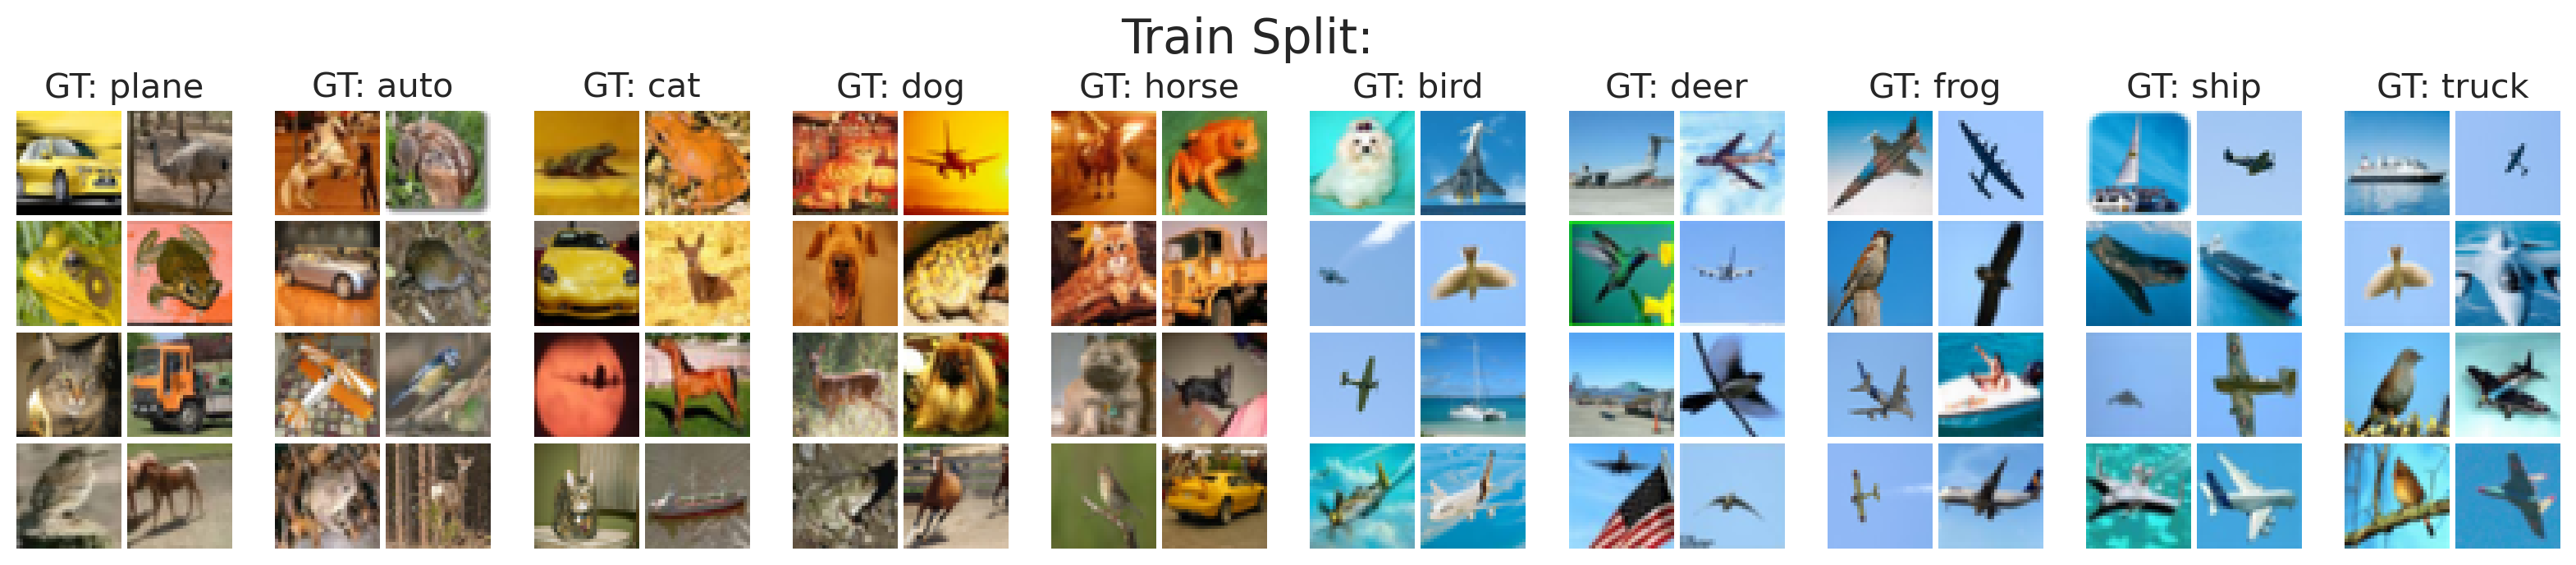

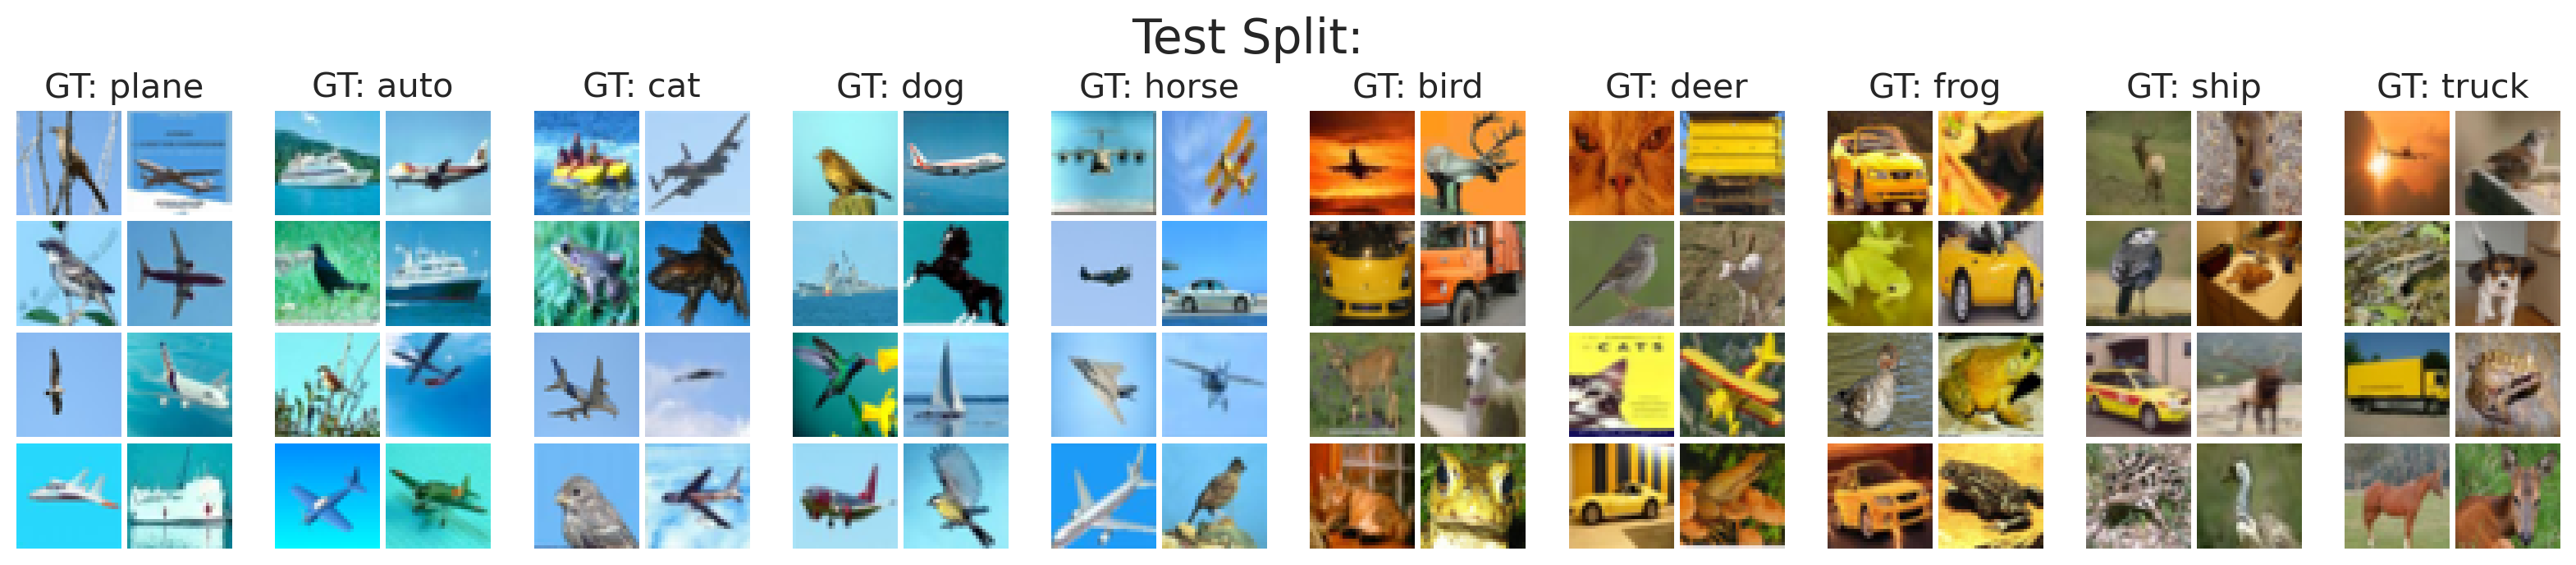

In [10]:
plot_train_test_split(27, 0)